## Overview:

 The Boston Marathon is an annual marathon hosted by several cities in greater Boston in eastern Massachusetts, United States. The data is downloaded from Kaggle. Our data is ** Finishers Boston Marathon 2017**. It contains 26410 rows and 25 variables. 

### In this analysis, we are doing:
* Data description
* Exploratory data analysis
* Data modeling

## Part1: Data Description:


### * Content:
According to their offical data information from this website: *http://registration.baa.org/2017/cf/Public/iframe_Statistics.htmThe* we know that 97% of participants finished the marathon. 


### * Description:
In this dataset, we have 25 Variables: *Name, Age, Gender, Country, City and State (where available), Times at 9 different stages of the race, expected time, Finish time and Pace, Overall place, Gender place and Division place*. The dataset is clean. There are only some NaN in "Citizen" variables, but for other variables, all of them contains values. In our analysis, we did not use the variable "Citizen" since it does not give any useful insights of our analysis.


### * Data recode
Since the "Country" variable has too many levels, we decide to recode this variable down to 2 levles: "1" for USA participants, "0" otherwise, we want to see if there is significant difference in finish time for people from US and outside from US.

## Part2：Exploratory Data Analysis:

In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('marathon_results_2017.csv')
print(data.shape)
print(data.info())
print(data.describe())
# as we can see, there is 26410 rows and 25 variables,
#not many NaN values.

(26410, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26410 entries, 0 to 26409
Data columns (total 25 columns):
Unnamed: 0       26410 non-null int64
Bib              26410 non-null object
Name             26410 non-null object
Age              26410 non-null int64
M/F              26410 non-null object
City             26410 non-null object
State            22815 non-null object
Country          26410 non-null object
Citizen          1254 non-null object
Unnamed: 9       91 non-null object
5K               26410 non-null object
10K              26410 non-null object
15K              26410 non-null object
20K              26410 non-null object
Half             26410 non-null object
25K              26410 non-null object
30K              26410 non-null object
35K              26410 non-null object
40K              26410 non-null object
Pace             26410 non-null object
Proj Time        26410 non-null object
Official Time    26410 non-null object
Overall          26410 non-

# Marathon Participants 
### 1: By Age
### 2: By Gender
### 3: By Country(recode)

In [3]:
#convert "official time" format to minutes, it's eary to calculate 
def convert_to_minutes(time):
    minutes = time.str.split(':').map(lambda x: int(x[-1]) / 60 + int(x[-2]) + int(x[-3]) * 60)
    return minutes
data['Time_Minutes'] = convert_to_minutes(data['Official Time'])
data.loc[:,['Official Time','Time_Minutes']].head()

,Official Time,Time_Minutes
0,2:09:37,129.616667
1,2:09:58,129.966667
2,2:10:28,130.466667
3,2:12:08,132.133333
4,2:12:35,132.583333


In [4]:
#Calcualte mean of finish time for each age group
time = data.loc[:,['Time_Minutes']]
decade = pd.cut(data.Age,bins=np.arange(10,99,10),right=False)
time["DECADE"] = decade
summary = time.groupby('DECADE')['Time_Minutes'].mean()
summary.index = np.arange(10,90,10) 
print(summary)   
#fastest group is 30-39 years old

10    255.197090
20    232.576644
30    228.135193
40    235.063972
50    246.556823
60    265.788384
70    292.434007
80    296.754762
Name: Time_Minutes, dtype: float64


### 1: Age and Gender Distribution

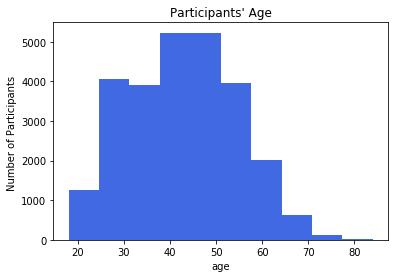

In [5]:
plt.hist(data.Age,color='royalblue')  #the age varies from 18 to 84 years old.
plt.title("Participants' Age")
plt.xlabel("age")
plt.ylabel("Number of Participants ")
plt.show()

Text(0.5,1,'Participation in 2017')

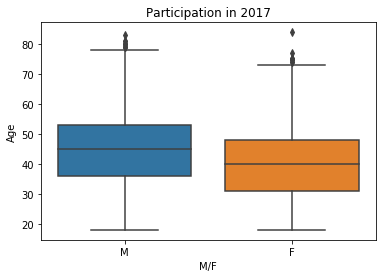

In [6]:
g = sns.boxplot(data['M/F'], data['Age'])
g.set_title("Participation in 2017")



### * Combine age and gender:

Text(0.5,1,'Participants by Age & Gender')

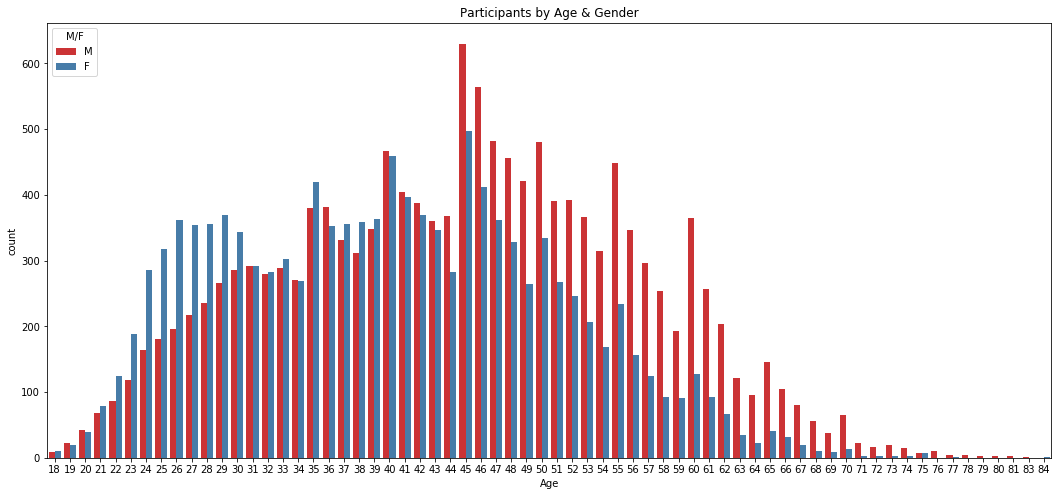

In [7]:
g = sns.countplot('Age', data=data, palette="Set1", hue='M/F')
g.figure.set_size_inches(18,8)
g.set_title("Participants by Age & Gender")

### * Country:

#### Top 15 Fastest Countries

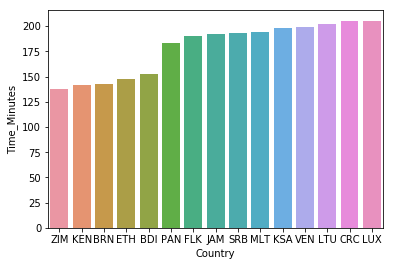

In [12]:
top_15_countries = data.groupby("Country")['Time_Minutes'].mean().nsmallest(15)

top15_countries = data.loc[data['Country'].isin(np.array(top_15_countries.index))]
top15_countries = top15_countries.groupby('Country')['Time_Minutes'].mean()
top15_countries = pd.DataFrame(top15_countries)
top15_countries = top15_countries.sort_values(['Time_Minutes'])
sns.barplot(x = top15_countries.index, y = top15_countries.Time_Minutes)

#### Worst 15 Countries

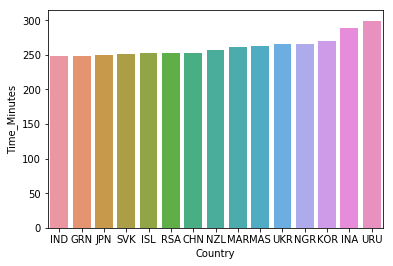

In [9]:
worst_15_countries = data.groupby("Country")['Time_Minutes'].mean().nlargest(15)

worst15_countries = data.loc[data['Country'].isin(np.array(worst_15_countries.index))]
worst15_countries = worst15_countries.groupby('Country')['Time_Minutes'].mean()
worst15_countries = pd.DataFrame(worst15_countries)
worst15_countries = worst15_countries.sort_values(['Time_Minutes'])
sns.barplot(x = worst15_countries.index, y = worst15_countries.Time_Minutes)

## Part3: Data modeling: